In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
sample = pd.read_excel("../Health_Sample dataset_SBP by month (1).xlsx").iloc[:, 1: ]
original = pd.read_excel("../iHealth Time Series - v1.xlsx")

## Exploratary Data Analysis

**Assumption 1**: We **filtered out patients with fewer than 5 records** (lower bound) because we cannot find patterns over time based on limited records.

**Assumption 2**: Since there are too many lines to be displayed in one plot, in order to make visualization more readable, we **grouped patients by their initial status and plotted different plots for each group**.

**Limitation**: Although we've done the grouping to have some subplots, for each subplot, there were still too many lines of which patterns cannot be detected. We've added the overall trends (average & median) for supplements. Given the limited columns in sample data, we can only group patients by their initial status. If we have more data available, there're more choices for grouping, i.e., **gender, age etc**, which, could have given more insightful information.

In [8]:
# number of the unique patient in the sample data
len(sample["memberId"].unique())

246

1. Remove patients with limited records

In [9]:
def filter_patients(df, group_field, lower_bound):
    grouped = df.groupby(group_field)
    filtered_indices = [idx for idx, group in grouped if len(group) >= lower_bound]
    filtered_df = df[df[group_field].isin(filtered_indices)]
    return filtered_df

In [67]:
# Assumption 1
lower_bound = 5
filtered_sample = filter_patients(sample, "memberId", lower_bound)

In [15]:
len(filtered_sample["memberId"].unique())

131

In [38]:
len(filtered_sample)

968

2. Group the patients

In [36]:
# Select initial records for each patient
def select_initial_records(df: pd.DataFrame, groupby_field: str, select_field: str, retain_fields: list):
    # Grouping by and getting the indices of max values within each group
    min_indices = df.groupby(groupby_field)[select_field].idxmin()
    
    # Extracting corresponding values based on min indices
    min_values = df.loc[min_indices, [groupby_field, *retain_fields]]
    
    return min_values

In [56]:
initial_records = select_initial_records(
    df=filtered_sample,
    groupby_field="memberId",
    select_field="month",
    retain_fields=["month", "systolic_mmHg"]
)

In [57]:
len(initial_records)

131

In [58]:
# Group function: group the dataframe by a given list as ranges
def group_by_ranges(df, field, new_field, ranges):
    # Create a function to categorize values based on the ranges
    def categorize_value(value):
        for idx, r in enumerate(ranges):
            if idx == len(ranges) - 1:
                if value > r:
                    return f">{r}"
            else:
                if r <= value < ranges[idx + 1]:
                    return f"{r}-{ranges[idx + 1]}"
    
    # Apply the categorization function to create a new column
    df[new_field] = df[field].apply(categorize_value)
    
    # Group the DataFrame based on the new column
    grouped_dataframes = [group for _, group in df.groupby(new_field)]
    
    return grouped_dataframes

In [59]:
# Group the patients based on initial blood pressure range
grouped_samples = group_by_ranges(
    initial_records,
    "systolic_mmHg",
    "systolic_mmHg_range_cat",
    [0.0, 120.0, 130.0, 140., 180.0]
)
print(len(grouped_samples))

5


In [60]:
# Distribution of initial blood pressures
print([len(df) for df in grouped_samples])

[12, 17, 36, 65, 1]


In [68]:
# Assign cat to all samples
cat_sample = filtered_sample.merge(pd.concat(grouped_samples)[["memberId", "systolic_mmHg_range_cat"]], on="memberId", how="left")

In [69]:
len(cat_sample)

968

In [70]:
cat_sample.head()

,memberId,month,systolic_mmHg,systolic_mmHg_range_cat
0,62a260c03b64e85e96af1d20,2022-07-01,133.08,130.0-140.0
1,62a260c03b64e85e96af1d20,2022-08-01,131.00,130.0-140.0
2,62a260c03b64e85e96af1d20,2022-09-01,130.88,130.0-140.0
3,62a260c03b64e85e96af1d20,2022-10-01,132.91,130.0-140.0
4,62a260c03b64e85e96af1d20,2022-11-01,127.75,130.0-140.0


3. Plot for each patient group

In [125]:
def plot_patient_trend(df: pd.DataFrame, cat_field_name: str, x_field_name: str, y_field_name: str):
    for idx, group in df.groupby(cat_field_name):
        plt.figure(figsize=(10, 6))

        # Get unique patients
        unique_patients = group['memberId'].unique()
        print(f"Num of unique patients: {len(unique_patients)}")

        # Plot each patient's trends
        for patient_id in unique_patients:
            patient_data = group[group['memberId'] == patient_id]
            plt.plot(patient_data[x_field_name], patient_data[y_field_name])

        # Adding labels and title
        plt.xlabel('Month')
        plt.ylabel('Systolic Blood Pressure (mmHg)')
        plt.title('Systolic Blood Pressure Change Over Months for Each Patient')
        
        # set the date limit and interval
        plt.xlim(pd.Timestamp('2022-06-01'), pd.Timestamp('2023-06-01')) 
        # Set x-axis ticks and labels for monthly intervals
        plt.xticks(pd.date_range(start='2022-06-01', end='2023-06-01', freq='MS'), rotation=45)      
        
        plt.grid(True)  # Show gridlines
        plt.tight_layout()

Num of unique patients: 12
Num of unique patients: 17
Num of unique patients: 36
Num of unique patients: 65
Num of unique patients: 1


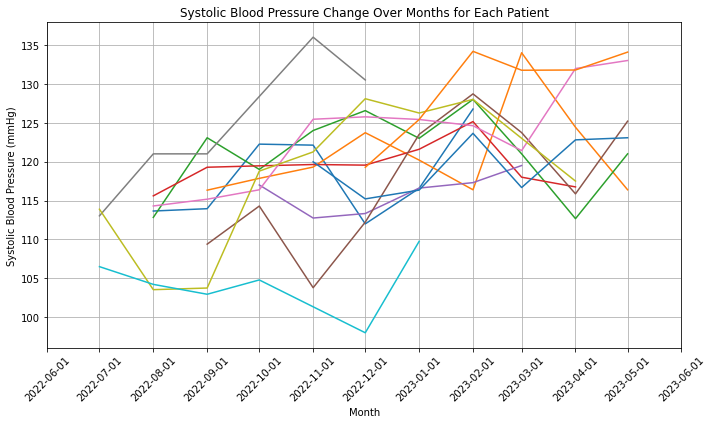

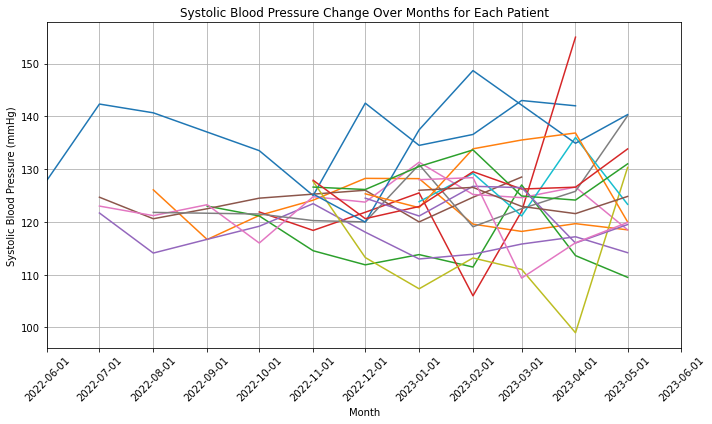

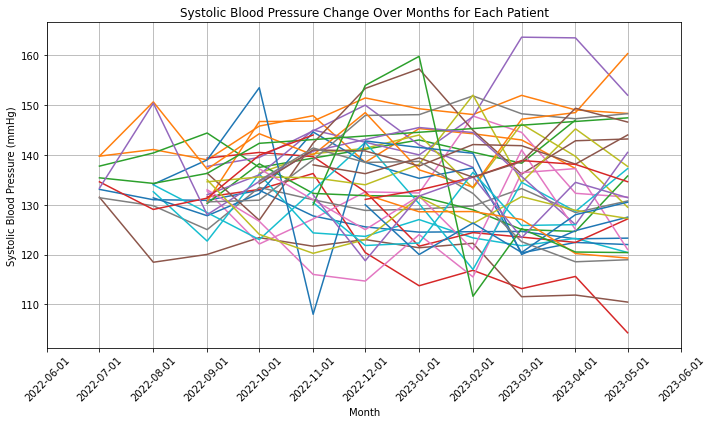

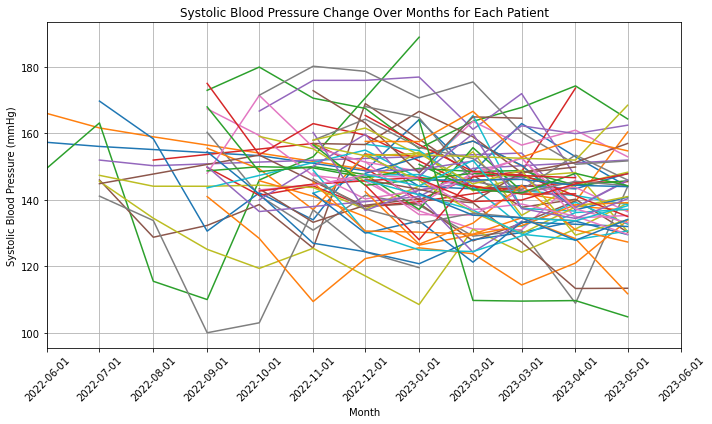

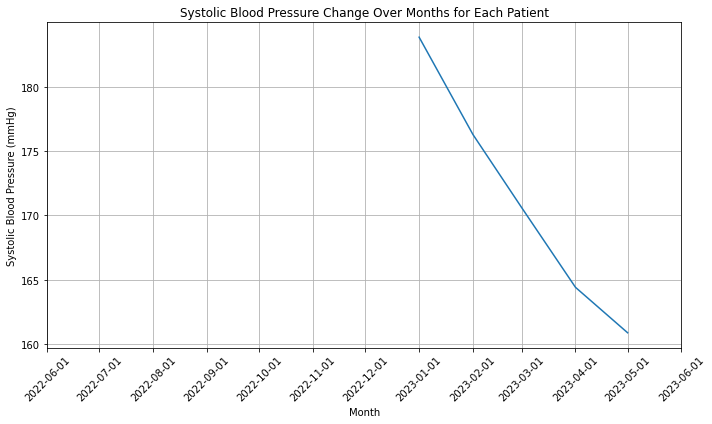

In [127]:
# plot for all patients
plot_patient_trend(
    cat_sample, 
    cat_field_name="systolic_mmHg_range_cat",
    x_field_name="month", 
    y_field_name="systolic_mmHg"
)

4. plot the overall trend.

For the subplots above, the blood pressure patterns over time is hard to spot. That's why we added the overal trend plot.

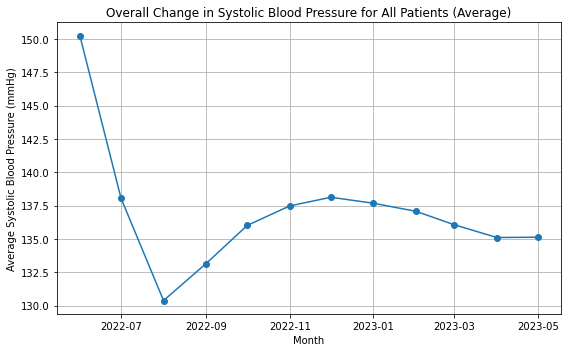

In [143]:
# Average Systolic Blood Pressure

# Calculate average systolic blood pressure for each month across all patients
avg_sbp_per_month = cat_sample.groupby('month')['systolic_mmHg'].mean()

# Plotting the overall change in blood pressure
plt.figure(figsize=(8, 5))

plt.plot(avg_sbp_per_month.index, avg_sbp_per_month.values, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Average Systolic Blood Pressure (mmHg)')
plt.title('Overall Change in Systolic Blood Pressure for All Patients (Average)')
plt.grid(True)
plt.tight_layout()


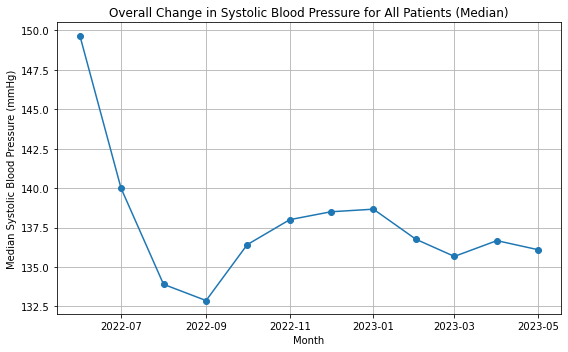

In [142]:
# Median Systolic Blood Pressure

avg_sbp_per_month = sample.groupby('month')['systolic_mmHg'].median()
plt.figure(figsize=(8, 5))

plt.plot(avg_sbp_per_month.index, avg_sbp_per_month.values, marker='o', linestyle='-')

plt.xlabel('Month')
plt.ylabel('Median Systolic Blood Pressure (mmHg)')
plt.title('Overall Change in Systolic Blood Pressure for All Patients (Median)')
plt.grid(True)
plt.tight_layout()

## Detailed Questions

Firstly, we selected the records that are **BP type**.

Secondly, based on the definition of BP category which takes patient’s BP readings from the latest day of a week, we **limited every patient's record to the latest day of a week per week** because for every patient per week, he has several measurement records.

In [540]:
df = pd.read_excel("../iHealth Time Series - v1.xlsx")

In [541]:
# filter bp type
df = df[df["type"] == "BP"]

In [542]:
# limit every patient's record to the latest day of a week per week


# Get the day of the week (Monday=0, Sunday=6)
df['day_of_week'] = df['datetime_utc'].dt.dayofweek

# Get the #th of the week
df['number_of_week'] = df['datetime_utc'].dt.week

# get the year
df['year'] = df['datetime_utc'].dt.year

# find the latest measurement per week per patient
unique = df[["EPR ID", "datetime_utc", "number_of_week", "year", "day_of_week"]].groupby(["EPR ID", "number_of_week", "year"]).max().reset_index()
df = unique[["EPR ID", "datetime_utc"]].merge(df, on=["EPR ID", "datetime_utc"])


In [543]:
# tag BP category
def BP_category(row):
    if (row['systolic BP_mmHg'] < 120) and (row['diastolic BP_mmHg'] < 80):
        return "Normal"
    elif (row['systolic BP_mmHg'] >= 120) and (row['systolic BP_mmHg'] <= 129) and (row['diastolic BP_mmHg'] < 80):
        return "Elevated"
    elif (row['systolic BP_mmHg'] > 180) or (row['diastolic BP_mmHg'] > 120):
        return "Hypertensive Crisis"
    elif ((row['systolic BP_mmHg'] >= 140) and (row['systolic BP_mmHg'] <= 180)) or ((row['diastolic BP_mmHg'] >= 90) and (row['diastolic BP_mmHg'] <= 120)):
        return "Hypertention Stage 2"
    elif ((row['systolic BP_mmHg'] >= 130) and (row['systolic BP_mmHg'] <= 139)) or ((row['diastolic BP_mmHg'] >= 80) and (row['diastolic BP_mmHg'] <= 89)):
        return "High Blood Pressure Stage 1"
    else:
        return "Others"

df['bp_category'] = df.apply(BP_category, axis=1)

In [544]:
# tag BP controlled
df["bp_controlled"] = df["bp_category"].apply(lambda x: "Uncontrolled" if (x == "Hypertensive Crisis") or (x == "Hypertention Stage 2") else "Controlled")


In [549]:
print("Number of unique patients in original data:")
print(len(df["EPR ID"].unique()))

Number of unique patients in original data:
258


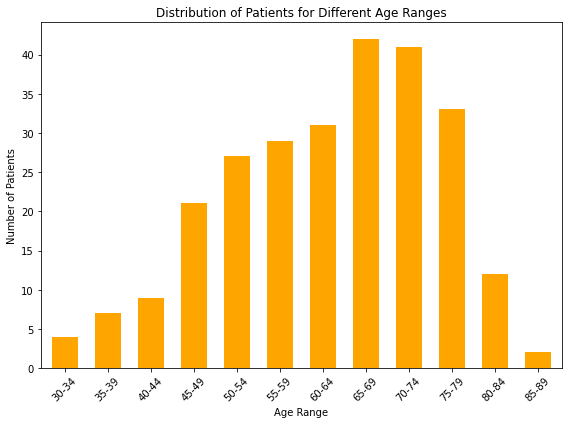

In [561]:
# plot the distribution of age
plt.figure(figsize=(8, 6))
bar_width = 0.6
df[["EPR ID", "age_range", "Gender"]].drop_duplicates()["age_range"].value_counts().sort_index().plot(kind='bar', color='orange', width=bar_width)

plt.title('Distribution of Patients for Different Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [562]:
df[["EPR ID", "age_range", "Gender"]].drop_duplicates()["Gender"].value_counts()

M    141
F    117
Name: Gender, dtype: int64

### 1.	How many months needed for patient from uncontrolled to controlled?

**Assumption 1**: There are patients who are still categorized as uncontrolled after treatment. So we excluded data points of those patients who are consistently uncontrolled and calculated the average months needed for patient from uncontrolled to controlled.

**Assumption 2**: There are patients whose status might **fluctuate** (i.e., from uncontrolled to controlled and turned to uncontrolled again. **We calculated the time interval for the patients when they first turned into controlled from initially uncontrolled**.

**Assumption 3**: We assume **30 days per month**.

1. Select qualified patients

In [264]:
# sort values based on 'EPR ID' and 'datetime_utc'
df = df.sort_values(by=['EPR ID', 'datetime_utc'])

In [265]:
# select the initial records at the first week per patient
df_initial = df.groupby('EPR ID').first().reset_index()
df_initial_un = df_initial[df_initial["bp_controlled"] == "Uncontrolled"]

In [266]:
# select the initial uncontrolled records with its later controlled status
df_uncon2con = pd.DataFrame()
for i in df_initial_un["EPR ID"].tolist():
    controlled_record = df[(df["EPR ID"] == i) & (df["bp_controlled"] == "Controlled")]
    if len(controlled_record) != 0:
        controlled_first = controlled_record.head(1)
        df_uncon2con = df_uncon2con.append(df_initial_un[df_initial_un["EPR ID"]==i], ignore_index=True).append(controlled_first, ignore_index=True)
    

2. Count avg months

In [267]:
# calculate the average
df_un = df_uncon2con[df_uncon2con["bp_controlled"] == "Uncontrolled"][["EPR ID", "datetime_utc"]]
df_con = df_uncon2con[df_uncon2con["bp_controlled"] == "Controlled"][["EPR ID", "datetime_utc"]]
df_uncon2con_date = df_un.merge(df_con, on="EPR ID")

In [268]:
df_uncon2con_date["month_diff"] = df_uncon2con_date["datetime_utc_y"] - df_uncon2con_date["datetime_utc_x"]
average_month_difference = df_uncon2con_date['month_diff'].mean()

In [277]:
# assuming 30 days per month
print(f"About {len(df_uncon2con_date)} patients who were from uncontrolled to controlled.")
print(f"About {average_month_difference / pd.Timedelta(days=30)} months needed for patient from uncontrolled to controlled.")


About 100 patients who were from uncontrolled to controlled.
About 1.4236206828703704 months needed for patient from uncontrolled to controlled.


### 2.	For well controlled patients at baseline, is it well maintained?

**Assumption 1**: We defined controlled patients at baseline as the patients who were controlled patients **initially**.

1. Find controlled patients at baseline

In [351]:
df_initial_con = df_initial[df_initial["bp_controlled"] == "Controlled"]

2. Find con/uncon status changing over time

In [369]:
df_con_initial_cnt = df[df["EPR ID"].isin(df_initial_con["EPR ID"].tolist())].groupby(["EPR ID", "bp_controlled"]).count().reset_index().groupby(["EPR ID"]).count().reset_index()[["EPR ID", "bp_controlled"]]


3. Define metrics: overall / grouped

In [381]:
# overall pattern
cnt_con_initial = len(df_con_initial_cnt)
cnt_change = len(df_con_initial_cnt[df_con_initial_cnt["bp_controlled"] == 2])
cnt_maintain = len(df_con_initial_cnt[df_con_initial_cnt["bp_controlled"] == 1])
ratio_change = len(df_con_initial_cnt[df_con_initial_cnt["bp_controlled"] == 2]) / len(df_con_initial_cnt)
ratio_maintain = len(df_con_initial_cnt[df_con_initial_cnt["bp_controlled"] == 1]) / len(df_con_initial_cnt)
print(f"There were {cnt_con_initial} number of well controlled patients at baseline.")
print(f"{cnt_change} out of {cnt_con_initial} changed and {cnt_maintain} out of {cnt_con_initial} were well maintained.")
print(f"{ratio_change * 100} % changed. {ratio_maintain * 100} were well maintained.")      


There were 108 number of well controlled patients at baseline.
79 out of 108 changed and 29 out of 108 were well maintained.
73.14814814814815 % changed. 26.851851851851855 were well maintained.


In [391]:
# patterns in subgroup (gender)
df[df["EPR ID"].isin(df_con_initial_cnt.loc[df_con_initial_cnt["bp_controlled"] == 2, "EPR ID"].tolist())][["EPR ID", "Gender"]].drop_duplicates().groupby("Gender").count()


,EPR ID
Gender,
F,33
M,46


In [393]:
# patterns in subgroup (age)
df[df["EPR ID"].isin(df_con_initial_cnt.loc[df_con_initial_cnt["bp_controlled"] == 2, "EPR ID"].tolist())][["EPR ID", "age_range"]].drop_duplicates().groupby("age_range").count()


,EPR ID
age_range,
30-34,1
35-39,4
40-44,1
45-49,7
50-54,6
55-59,7
60-64,14
65-69,8
70-74,12


### 3.	For patients from uncontrolled to controlled, is it well maintained or easy to be uncontrolled again?

1. Find patients from uncontrolled to controlled

In [567]:
# df_initial_all is all records for patients from uncontrolled to controlled
df_initial_all = df[df['EPR ID'].isin(df_uncon2con["EPR ID"].drop_duplicates())]
df_initial_all = df_initial_all.sort_values(by=['EPR ID', 'datetime_utc'])

In [568]:
# create the df_after dataframe containing the records after patients are controlled
df_after = pd.DataFrame()
for i in range(len(df_con)):
    if len(a) != 0:
        a = df_initial_all[(df_initial_all["EPR ID"] == df_con["EPR ID"].iloc[i]) & (df_initial_all["datetime_utc"] >= df_con["datetime_utc"].iloc[i])]
        df_after = df_after.append(a, ignore_index=True)

# if cnt is 2 in df_after_cnt, it means the patient condition fluctuate; if it's 1 it means it remains as controlled afterwards 
df_after_cnt = df_after.groupby(["EPR ID", "bp_controlled"]).count().reset_index().groupby(["EPR ID"]).count().reset_index()

2. Define metrics: overall / grouped

In [569]:
print("Patients became uncontrolled again: ")
print(len(df_after_cnt[df_after_cnt["bp_controlled"] == 2]) / len(df_after_cnt))

Patients became uncontrolled again: 
0.85


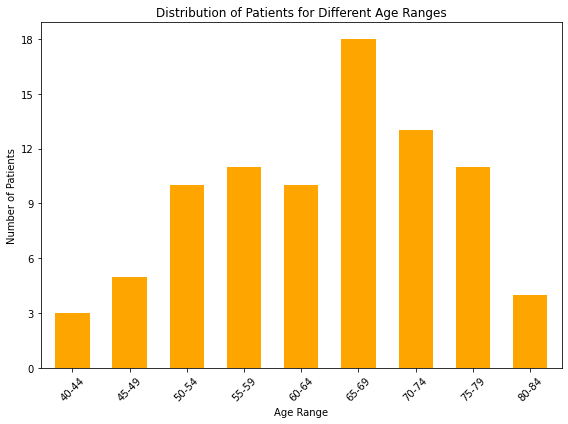

In [586]:
# find if has patterns in age
# plot the distribution of age
plt.figure(figsize=(8, 6))
bar_width = 0.6
df[df["EPR ID"].isin(df_after_cnt.loc[df_after_cnt["bp_controlled"] == 2, "EPR ID"].tolist())][["EPR ID", "age_range", "Gender"]].drop_duplicates()["age_range"].value_counts().sort_index().plot(kind='bar', color='orange', width=bar_width)

plt.title('Distribution of Patients for Different Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.yticks(range(0, 21, 3))
plt.tight_layout()
plt.show()

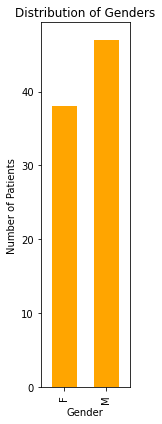

In [592]:
# find if has patterns in gender
# plot the distribution of gender
plt.figure(figsize=(2, 6))
bar_width = 0.6
df[df["EPR ID"].isin(df_after_cnt.loc[df_after_cnt["bp_controlled"] == 2, "EPR ID"].tolist())][["EPR ID", "age_range", "Gender"]].drop_duplicates()["Gender"].value_counts().sort_index().plot(kind='bar', color='orange', width=bar_width)

plt.title('Distribution of Genders')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

### 4.	For patients always uncontrolled, what are the vitals patterns?

**Assumption 1**: We defined patients always uncontrolled as patients who've **never** become as controlled.

**Assumption 2**: We looked at Vitals Patterns based on the distribution of **age, gender**, and the proportion of people who are **arrhythmic**.

1. Find patients always uncontrolled

In [594]:
df_always = df.groupby(["EPR ID", "bp_controlled"]).count().reset_index().groupby(["EPR ID"]).count().reset_index()
df_always = df_always[df_always["bp_controlled"] == 1]
# at this time, df_always contain the patients who consistently as conrolled and who consistently as uncontrolled

In [595]:
# delete patients that are consistently controlled
a = df.groupby(["EPR ID", "bp_controlled"]).count().reset_index()
con_list = a.loc[a["bp_controlled"] == "Controlled", "EPR ID"].drop_duplicates()
df_always = df_always[~df_always["EPR ID"].isin(con_list)]
df_always = df[df["EPR ID"].isin(df_always["EPR ID"].tolist())]

In [596]:
df_always_unique = df_always[["EPR ID", "age_range", "Gender"]].drop_duplicates()
print(f"There are total {len(df_always_unique)} patients who are consistently as uncontrolled.")

There are total 50 patients who are consistently as uncontrolled.


2. Analyze the vital patterns (distribution, correlation)

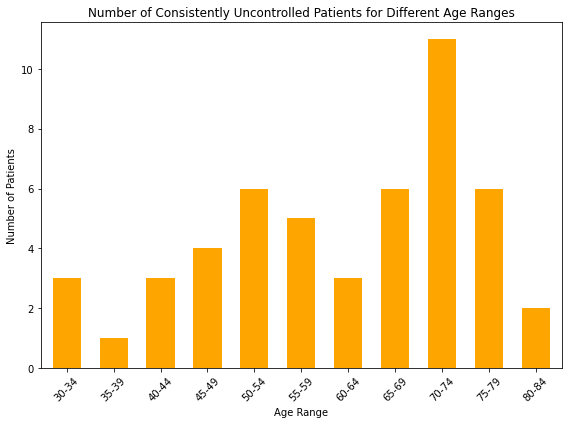

In [598]:
# age distribution for patients who are consistently uncontrolled
plt.figure(figsize=(8, 6))
bar_width = 0.6
df_always_unique['age_range'].value_counts().sort_index().plot(kind='bar', color='orange', width=bar_width)

plt.title('Number of Consistently Uncontrolled Patients for Different Age Ranges')
plt.xlabel('Age Range')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

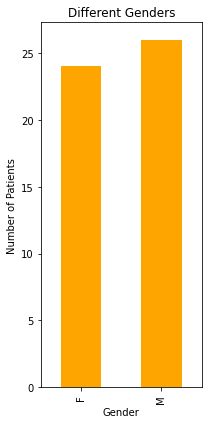

In [603]:
# gender distribution for patients who are consistently uncontrolled
plt.figure(figsize=(3, 6))
# bar_width = 0.1
df_always_unique['Gender'].value_counts().sort_index().plot(kind='bar', color='orange')

plt.title('Different Genders')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

In [461]:
# find proportion of arrhythmic
df_always_arrhythmic = df_always[["EPR ID", "age_range", "Gender", "arrhythmic"]].groupby(["EPR ID", "arrhythmic"]).count().reset_index()
print(f"For total 50 patients who were always uncontrolled, there are only 1 patients who was arrhythmic all the time; 47 patients who were arrhythmic normal; and 2 patients who were arrhythmic several times.")


For total 50 patients who were always uncontrolled, there are only 1 patients who was arrhythmic all the time; 47 patients who were arrhythmic normal; and 2 patients who were arrhythmic several times.


### 5.	What’s the pattern for vital monitoring activity? Should we set up a graduation timeline?

**Assumption 1**: We want to figure out the relationship between BP status and whether taking medication.

**Assumption 2**: We did patients segmentation based on their frequency to take medication.

In [530]:
# calculate the frequency to take medication per patient
df_med = df[["EPR ID", "took_medication"]].groupby(["EPR ID"]).mean().reset_index()
df_med["freq_med"] = df_med["took_medication"].apply(lambda x: "over 0.5" if x >= 0.5 else "less 0.5")
df_med

,EPR ID,took_medication,freq_med
0,62acbe2396f015001286cd92,0.50,over 0.5
1,62b0bf4a859f85001452d9df,0.55,over 0.5
2,62b0c195859f850014535318,0.95,over 0.5
3,62b0c476caf1790013c35cb8,0.60,over 0.5
4,62b33cf30b506a0012c7bbcb,0.50,over 0.5
...,...,...,...
253,646bde18da981400135e487a,0.50,over 0.5
254,646d16063e08d70013b7299f,0.00,less 0.5
255,646d1b88576e390014392a33,1.00,over 0.5
256,646e3c91bc775e001382de30,0.00,less 0.5


In [531]:
df_med["freq_med"].value_counts()

over 0.5    148
less 0.5    110
Name: freq_med, dtype: int64

In [532]:
# for all uncontrolled to controlled patients, how many of their medication frequency is over 0.5?
num = 0
for i in df_med.loc[df_med["EPR ID"].isin(df_uncon2con["EPR ID"].unique().tolist()), "EPR ID"].tolist():
    if i in df_med.loc[df_med["freq_med"] == "over 0.5", "EPR ID"].tolist():
        num += 1
print(f"Total patients from uncontrolled to controlled: {len(df_uncon2con_date)};")
print(f"{num} out of total have medication frequency over 0.5.")

Total patients from uncontrolled to controlled: 100;
66 out of total have medication frequency over 0.5.


In [536]:
# Creating a contingency table (cross-tabulation)
contingency_table = pd.crosstab(df['took_medication'], df['bp_controlled'])
contingency_table

bp_controlled,Controlled,Uncontrolled
took_medication,,
0.0,1004,787
1.0,1141,878


In [539]:
# Performing chi-square test for independence
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")


Chi-Square Test Results:
Chi-square statistic: 0.06245648274514882
P-value: 0.8026546680266418


The p-value resulting from the chi-square test indicates the probability of observing the data's association between the variables if they were actually independent. If the p-value is less than a chosen significance level (e.g., 0.05), it suggests a significant association between the variables.

However, the P value is **0.8** which indicates there's **no significant association** between took_medication and controlled.